##### Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Problem statement

This is a chart of observations from a Wilrich reservoir example **(mitigating drilling risk due to open fracture systems)**.

From a case studies presented by Lee Hunt (at the time at Jupiter Resources) in [this CSEG talk](http://cseg.ca/technical/view/value-thinking-from-the-classical-to-the-hyper-modern).

In [2]:
data = pd.read_csv('predict_drilling_problem.csv', index_col=0)
data

,Curvature,Diffraction_imaging,Coherence,AVAz,VVAZ,Problem
Well,,,,,,
A,True,True,False,True,True,True
B,True,True,True,False,True,True
C,False,False,True,True,False,False
D,False,True,False,False,True,False
E,True,False,False,True,True,False
F,True,True,False,False,False,True
G,True,True,True,True,True,True


The background is that there was a known history of drilling and losing some wells in this area due to mud loss when encountering large systems of open fractures. Jupyter had done extensive geophysical work, using multiple attributes typically correlating with fractures, but had no calibration data (i.e. fracture density form image logs), and some of the attributtes yield poor or conflicting results.

##### Solution 1 - Mill's Methods of Induction

Jupyter decided to try **Mill's Methods of Induction**, as examplified in Lee Hunt's talk, to see which attribute (or set of) could predict the drilling problems in the absence of validation.

Mill's methods are described in Chapter VIII (page 450) of [his book](https://books.google.ca/books?id=y4MEAAAAQAAJ).


The desired outcome of this attempt was the identification of the 'problem' pattern, which could then be applied to future wells. Then "upcoming well locations that had the same 'symptoms' (Mill's method is often illustraded with a [food poisoning example](http://philosophy.hku.hk/think/sci/mill.php)) could be identified ahead of time, and so one could chose to pick a different location, or move ahead but with the drilling department warned and ready.....

We can look at the table above as binary labels:

In [3]:
data.astype(int)

,Curvature,Diffraction_imaging,Coherence,AVAz,VVAZ,Problem
Well,,,,,,
A,1,1,0,1,1,1
B,1,1,1,0,1,1
C,0,0,1,1,0,0
D,0,1,0,0,1,0
E,1,0,0,1,1,0
F,1,1,0,0,0,1
G,1,1,1,1,1,1


The "problem wells" column is compiled by the geologist in collaboration with the drilling department (to identify with certainty the wells that had the problem); the observation columns are compiled by the geophysicist.

Jupyter's results from applying Mill's method are not shown in the webcast. 

I was tempted to try it myself, and made some initial considerations:

- in 4/4 cases when the problem occurrs both curvature and diffraction imaging are observed
- each of curvature and diffraction imaging are observed with the absence of problem in 2/3 cases
- coherence is observed in 2/4 cases when the problem occurs and not observed in 2/3 cases when it does not
- AVAz is observed in 2/4 cases when the problem occurs and not observed in 1/3 cases when it does not
- VVAz also is observed in 2/4 cases when the problem occurs and not observed in 1/3 cases when it does not


But the more I looked at this table the more I was becoming curious to see if a neural network might figure out the pattern and perhaps tell me which observations / attributes were the key ones. I think it worked. 

##### Solution 2 - simple numpy 2-layer neural network

Here's how I went about it. The neural network is adapted from [A Neural Network in 11 lines of Python (Part 1): 2-layer network](http://iamtrask.github.io/2015/07/12/basic-python-network). Also, for a great intuition about backpropagation, with pure numpy code, check [this section](http://cs231n.github.io/optimization-2) of the course [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io).

First I created separate arrays for features (observations) and labels (the problem column):

In [4]:
X = np.array(data.astype(int).as_matrix())[:,:-1]
y = np.array(data.astype(int).as_matrix())[:,-1].reshape(7,1)
print X
print y

[[1 1 0 1 1]
 [1 1 1 0 1]
 [0 0 1 1 0]
 [0 1 0 0 1]
 [1 0 0 1 1]
 [1 1 0 0 0]
 [1 1 1 1 1]]
[[1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]]


Then I defined a logistic activation function for forward and back-propagation:

In [5]:
def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

A quick visual of the logistic activation function:

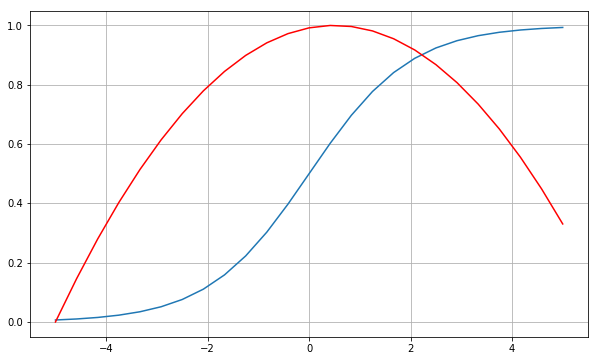

In [6]:
fig = plt.figure(figsize= (10, 6))
ax0 = fig.add_subplot(111)

test_x = np.linspace(-5, 5, 25)

ax0.plot(test_x, nonlin(test_x)) # logistic function
ax0.plot(test_x, (nonlin(test_x,True)-nonlin(test_x,True).min())
         /(nonlin(test_x,True).max()-nonlin(test_x,True).min()), 'r-') # derivative
                                                                       # normalized to display on same plot
plt.grid(True)
plt.show()

And here's a simple numpy 2-layer network in action, with some very simple visualizations:

Error:0.521171557881
Error:0.0260366511967
Error:0.0180108167259
Error:0.0145613498148
Error:0.0125362126251
Error:0.0111675364476
Error:0.0101641526307
Error:0.00938837994117
Error:0.00876562499071
Error:0.00825152666506
Error:0.00781784272301
Error:0.00744563091013
Error:0.00712165200176
Error:0.00683633816816
Error:0.0065825807639
Error:0.00635497370738
Error:0.00614932307667
Error:0.00596231890334
Error:0.00579130937575
Error:0.00563414172385


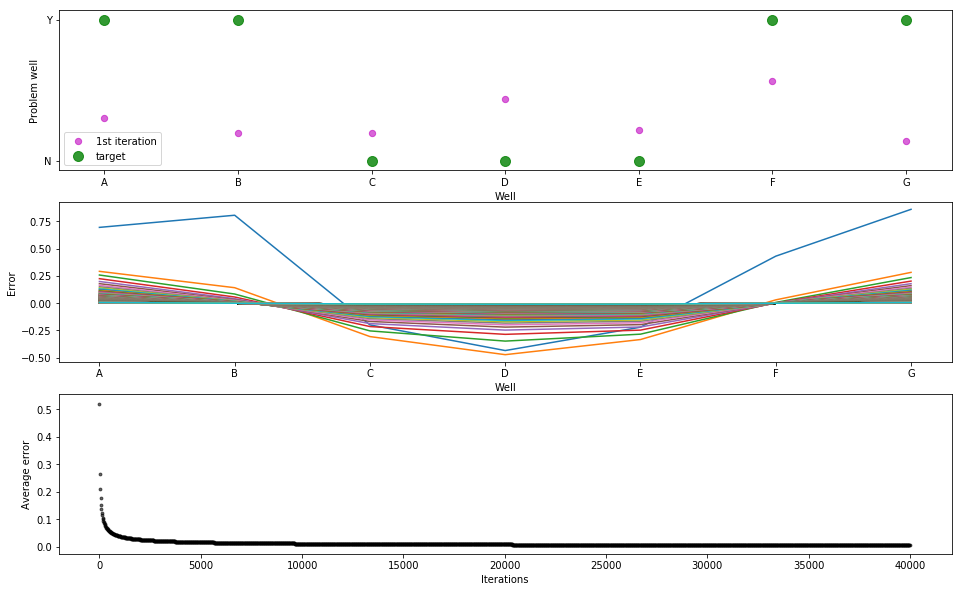

In [7]:
# seed random numbers to make calculation
# deterministic
np.random.seed(1)

fig = plt.figure(figsize= (16, 10))
ax0 = fig.add_subplot(311)
ax1 = fig.add_subplot(312)
ax2 = fig.add_subplot(313)

# initialize weights randomly with mean 0
syn0 = 2*np.random.random((5,1)) - 1

for j in xrange(40000):

    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1
        
    # print error
    if (j% 2000) == 0: 
        print "Error:" + str(np.mean(np.abs(l1_error)))

    # plot error
    if (j) == 0:
        ax0.scatter(np.arange(1,8), l1, s = 40, c = 'm', alpha = 0.6, label = '1st iteration');
        ax0.scatter(np.arange(1,8), y, s = 100, c = 'g', alpha = 0.8, label = 'target');
        ax0.set_xticks(np.arange(1,8))
        ax0.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
        ax0.set_yticks([0, 1])
        ax0.set_yticklabels(['N', 'Y'])
        ax0.set_xlabel('Well')
        ax0.set_ylabel('Problem well')
        ax0.legend()
        
    if (j% 20) == 0: 
        ax1.plot(np.arange(1,8), l1_error);
        ax1.set_xticks(np.arange(1,8))
        ax1.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
        ax1.set_xlabel('Well')
        ax1.set_ylabel('Error')
        ax2.scatter(j, np.mean(np.abs(l1_error)), s = 8, c = 'k', alpha = 0.6);
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Average error')
    
    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)

    # update weights
    syn0 += np.dot(l0.T,l1_delta)
    
plt.show()

The array with the he predicted labels is below:

In [8]:
np.set_printoptions(precision=2)

print "Output After Training:"
print l1

Output After Training:
[[ 0.99]
 [ 1.  ]
 [ 0.01]
 [ 0.01]
 [ 0.01]
 [ 1.  ]
 [ 0.99]]


The network did well. But the insight comes next, by looking at the final updated weights:

In [9]:
syn = [item for sublist in syn0 for item in sublist]
s = pd.Series(syn, index = list(data)[:-1])

pd.options.display.float_format = '{:,.3f}'.format
print s.to_string()

Curvature              14.587
Diffraction_imaging     9.741
Coherence               0.006
AVAz                   -4.937
VVAZ                  -14.465


The curvature and diffraction imaging were the key predictors; and while the coherence does not seem as relevant, the AVO anisotropy attributes are assigned negative weights (they are inhibited).

This needs a bit of chewing on. 

The way I was explained once how negative weights occur is with this Convolutional Neural Network example.
The network is given a set of pictures to classify. We want it to learn to identify ducks from:

A ==> pictures of birds

B ==> pictures of ducks

C ==> pictures of people, some with duck suits

with a training set:

T ==> pictures of ducks

In the end, the weights will be assigned as:

A +

B +++ (B >> A)

C -

This will inhibit the use of humans in duck suits.


So, back to the drilling problems, it appears that the AVO attributes are not predictive, and in fact gets assigned negative values. I mentioned to Lee Hunt  this neural network result, and he confirmed (personal communication) that the AVO attributes VVAz and AVAz were in fact problematic because the Wilrich amplitude was dominated by the effect of an overlying coal, and pointed me to some published work:

Precise 3D seismic steering and production rates in the Wilrich tight gas sands of West Central Alberta, Hunt et al., SEG, Interpretation May 2014

This is the equivalent of Mill's Method of residue: coal is known to be the cause of both the AVAz and VVAz observations, so they are not relevant to the dirlling problem.


##### Discussion and ideas for future work

I think this short experiment demonstrated that a simple network could be used to cull the seismic fracture attributes.

However, if we wanted to train a model and use it use predicatively it would not be without challenges.

This is a very small dataset, so if we wanted to train a model with crossvalidation (to avoid overfitting) we woud need more observations (more wells), or augment the dataset with an appropriate oversampling or shuffling strategy.

Having solve that problem I could:
- [use nested stratified-k fold to comparing models](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb#Algorithm-selection-with-nested-cross-validation)

- [save best model to predict future wells](http://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/bonus/scikit-model-to-json.ipynb)

But does it even make sense?
